In [3]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt
import os
import PIL
import pathlib

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 28s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


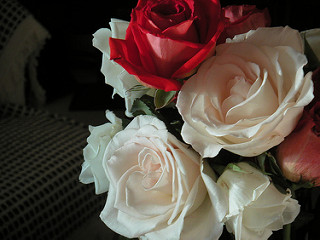

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

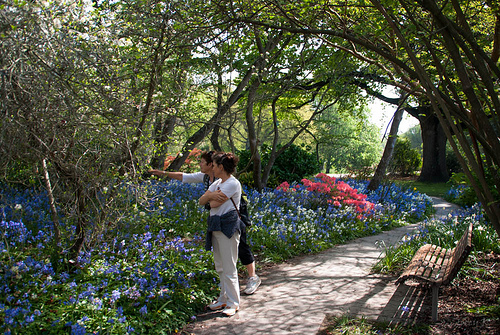

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

num_classes = 5
epochs = 15

## Dataset

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=11,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=11,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualization

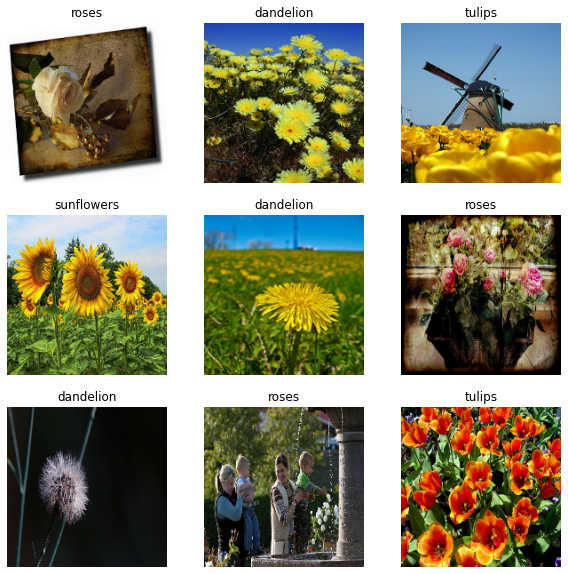

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # using prefetch for efficient model
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255) # pixels values are now in [0,1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model

In [16]:
model = keras.Sequential([
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 82s 888ms/step - loss: 1.2608 - accuracy: 0.4871 - val_loss: 1.0858 - val_accuracy: 0.5504
Epoch 2/15
92/92 [==============================] - 70s 760ms/step - loss: 0.9628 - accuracy: 0.6281 - val_loss: 0.9906 - val_accuracy: 0.6049
Epoch 3/15
92/92 [==============================] - 63s 683ms/step - loss: 0.7832 - accuracy: 0.7098 - val_loss: 0.8847 - val_accuracy: 0.6689
Epoch 4/15
92/92 [==============================] - 56s 612ms/step - loss: 0.5990 - accuracy: 0.7837 - val_loss: 0.8969 - val_accuracy: 0.6594
Epoch 5/15
92/92 [==============================] - 56s 607ms/step - loss: 0.3789 - accuracy: 0.8672 - val_loss: 1.0715 - val_accuracy: 0.6417
Epoch 6/15
92/92 [==============================] - 55s 596ms/step - loss: 0.2138 - accuracy: 0.9312 - val_loss: 1.2312 - val_accuracy: 0.6253
Epoch 7/15
92/92 [==============================] - 56s 606ms/step - loss: 0.1259 - accuracy: 0.9676 - val_loss: 1.4391 - val_accuracy: 0.6662

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

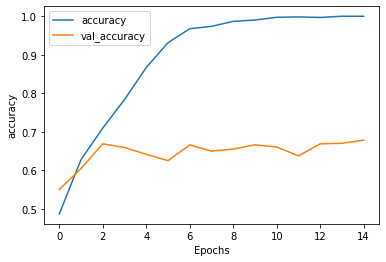

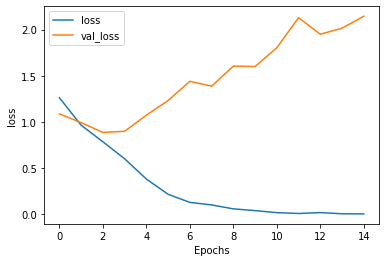

In [20]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

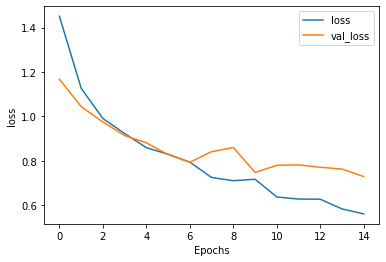

In [32]:
plot_graphs(history, 'loss') # Overfitting due to small data

## Data augmentation 

In [22]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

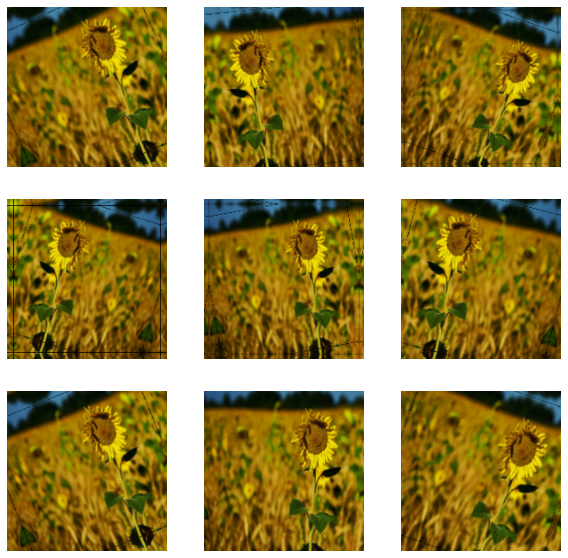

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
model = keras.Sequential([
  data_augmentation,
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [26]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 66s 712ms/step - loss: 1.4507 - accuracy: 0.4009 - val_loss: 1.1677 - val_accuracy: 0.5136
Epoch 2/15
92/92 [==============================] - 72s 781ms/step - loss: 1.1269 - accuracy: 0.5296 - val_loss: 1.0445 - val_accuracy: 0.5777
Epoch 3/15
92/92 [==============================] - 66s 717ms/step - loss: 0.9907 - accuracy: 0.6260 - val_loss: 0.9753 - val_accuracy: 0.6226
Epoch 4/15
92/92 [==============================] - 66s 712ms/step - loss: 0.9234 - accuracy: 0.6458 - val_loss: 0.9141 - val_accuracy: 0.6376
Epoch 5/15
92/92 [==============================] - 65s 707ms/step - loss: 0.8596 - accuracy: 0.6734 - val_loss: 0.8815 - val_accuracy: 0.6485
Epoch 6/15
92/92 [==============================] - 66s 720ms/step - loss: 0.8301 - accuracy: 0.6856 - val_loss: 0.8284 - val_accuracy: 0.6894
Epoch 7/15
92/92 [==============================] - 66s 713ms/step - loss: 0.7947 - accuracy: 0.6938 - val_loss: 0.7943 - val_accuracy: 0.7016

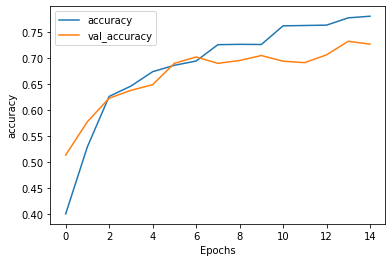

In [27]:
plot_graphs(history, 'accuracy')

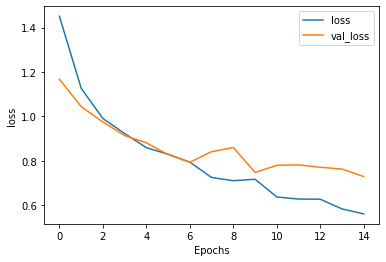

In [28]:
plot_graphs(history, 'loss')